# Librerias

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from keras import regularizers
import keras

pd.set_option("display.max_columns", None) 

# FUNCIONES

In [2]:
def missing_values_heatmap(data, num_columns_ini=0, num_columns=40, bar=True, ruta_guardado="../files/output/Graficos_tendencias/"):
    """
    Crea un mapa de calor para visualizar los valores faltantes en un rango de columnas especificado.
    
    Parámetros:
    - data: pd.DataFrame
        DataFrame que contiene los datos.
    - num_columns_ini: int, opcional (por defecto=0)
        Índice de la columna donde inicia la gráfica.
    - num_columns: int, opcional (por defecto=40)
        Índice de la columna donde termina la gráfica.
    - bar: bool, opcional (por defecto=True)
        Si True, muestra la gráfica; si False, la guarda en la ruta especificada.
    - ruta_guardado: str, opcional (por defecto="../files/output/Graficos_tendencias/")
        Ruta donde se guardará la imagen si bar=False.
    
    Retorna:
    - None (muestra o guarda el mapa de calor según el valor de 'bar').
    """
    # Selecciona las columnas dentro del rango especificado
    cols = data.columns[num_columns_ini:num_columns]
    
    # Especifica los colores: azul para datos presentes, amarillo para faltantes
    colours = ['#000099', '#ffff00']  
    
    # Genera el heatmap
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
    sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)
    
    # Crear directorio si no existe
    os.makedirs(ruta_guardado, exist_ok=True)
    
    if bar:
        plt.title("Mapa de calor de valores faltantes")
        plt.show()  # Muestra la gráfica
    else:
        filename = f"{num_columns_ini}-{num_columns}.png"
        filepath = os.path.join(ruta_guardado, filename)
        plt.title("Mapa de calor de valores faltantes")
        plt.savefig(filepath, bbox_inches='tight')  # Guarda la gráfica
        plt.close()  # Cierra la figura para liberar memoria
        print(f"Gráfica guardada en: {filepath}")  # Mensaje de confirmación

def tabla_datos_faltantes(df: pd.DataFrame) -> pd.DataFrame:
    """Crea una tabla que muestra el número de valores faltantes y su porcentaje para cada columna,
    junto con el tipo de característica que tiene valores faltantes.

    Parametros:
        df (pd.DataFrame): El DataFrame que contiene los datos.

    Return:
        pd.DataFrame: Un DataFrame que contiene el número de valores faltantes, su porcentaje y el tipo de característica.
    """
    # Total de valores nulos o perdidos
    mis_val = df.isnull().sum()
    # Porcentaje de valores nulos
    mis_percent = 100 * df.isnull().sum() / len(df)
    # Tipo de característica de cada columna
    tipos_de_caracteristicas = df.dtypes
    # Creamos una tabla con los resultados
    mis_table = pd.concat([mis_val, mis_percent, tipos_de_caracteristicas], axis=1)
    # Renombramos las columnas
    mis_table.columns = ['Valores Faltantes', 'Porcentaje de Valores Faltantes', 'Tipo de Característica']
    # Filtramos las columnas con valores faltantes
    mis_table = mis_table[mis_table['Valores Faltantes'] != 0].sort_values(by='Porcentaje de Valores Faltantes', ascending=False).round(2)

    print("El dataframe seleccionado tiene {} columnas.\n"
          "Hay {} columnas con valores perdidos.".format(df.shape[1], mis_table.shape[0]))

    return mis_table


def graficar_tendencias(df, nombre_columna, bar, ruta_guardado="../files/output/Graficos_tendencias/"):
    """
    Genera una gráfica con las tendencias de la demanda de energía usando medias móviles.
    
    Parámetros:
    df (DataFrame): DataFrame con una columna específica de demanda y un índice de fechas.
    nombre_columna (str): Nombre de la columna a graficar.
    bar (bool): Si es True, muestra la gráfica; si es False, la guarda en la ruta especificada.
    ruta_guardado (str): Ruta donde se guardará la imagen si bar es False.
    """
    # Configurar estilo de Seaborn
    sns.set_style("whitegrid")
    nombre_columna = nombre_columna.replace("\t", "")   # Elimina espacios completamente
   
    # Calcular medias móviles
    df_7d = df.rolling(7, center=True).mean()
    
    df_365d = df.rolling(365, center=True, min_periods=360).mean()

    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 6))

    # Graficar datos originales
    ax.plot(df.index, df, marker='.', markersize=2, color='gray', linestyle='None', alpha=0.6, label='Diario')
    ax.plot(df.index, df_7d, linewidth=2, color='blue', label='Media móvil semanal')
    ax.plot(df.index, df_365d, linewidth=3, color='darkred', label='Tendencia (Media anual)')

    # Configuración de la gráfica
    ax.legend()
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Demanda de energía')
    ax.set_title(f'Tendencias de la barra {nombre_columna}')
    plt.xticks(rotation=45)

    os.makedirs(ruta_guardado, exist_ok=True)

    if bar:
        plt.show()  # Muestra la gráfica si bar es True
    else:
        plt.savefig(ruta_guardado+nombre_columna+".png", bbox_inches='tight')  # Guarda la gráfica si bar es False
        plt.close()  # Cierra la figura para liberar memoria
        print(f"Gráfica guardada en: {ruta_guardado}{nombre_columna}.png")  # Mensaje de confirmación


def porcentaje_horas_con_cero(df):
    """
    Calcula el porcentaje de horas que tienen al menos un valor igual a 0 en el DataFrame.

    Parámetro:
    df (DataFrame): DataFrame con un índice de fechas y horas.

    Retorna:
    float: Porcentaje de horas con al menos un valor cero.
    """
    # Asegurar que el índice es datetime
    df.index = pd.to_datetime(df.index)
    
    # Agrupar por hora y verificar si hay al menos un cero
    horas_con_cero = (df == 0).any(axis=1).groupby(df.index.hour).sum()
    
    
    print("Horas con al menos un valor cero por cada hora del día:")
    print(horas_con_cero)


def boxplot_each_column(df, bar, ruta_guardado="../files/output/Graficos_Oulayer/", name="boxplot"):
    """
    Crea un boxplot para cada columna en un DataFrame y lo guarda en formato PDF con 4 gráficos por hoja.

    Parámetros:
    - df: pandas DataFrame
        El DataFrame que contiene los datos.
    - bar: bool
        Si es True, muestra la gráfica. Si es False, la guarda en la ruta especificada.
    - ruta_guardado: str, opcional
        Carpeta donde se guardará el PDF si `bar` es False.
    - name: str, opcional
        Nombre del archivo de salida.

    Retorna:
    - None
    """
    # Verificar si la ruta de guardado existe, si no, crearla
    if not os.path.exists(ruta_guardado):
        os.makedirs(ruta_guardado)

    filepath = os.path.join(ruta_guardado, f"{name}.pdf")

    if bar:
        num_cols = len(df.columns)
        num_rows = (num_cols + 2) // 3  # Calcula el número de filas necesarias
        plt.figure(figsize=(15, 3 * num_rows))

        for i, column in enumerate(df.columns):
            plt.subplot(num_rows, 3, i + 1)
            sns.boxplot(x=df[column])
            plt.title(column)
            plt.xlabel(column)

        plt.tight_layout()
        plt.show()

    else:
        with PdfPages(filepath) as pdf:
            num_cols = len(df.columns)
            for i in range(0, num_cols, 4):  # Procesar de 4 en 4 columnas
                fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Crear hoja con 4 gráficos
                axes = axes.flatten()  # Convertir la matriz de ejes en una lista
                
                for j, column in enumerate(df.columns[i:i+4]):  # Iterar sobre 4 columnas por página
                    sns.boxplot(x=df[column], ax=axes[j])
                    axes[j].set_title(column)
                    axes[j].set_xlabel(column)

                # Ocultar ejes vacíos si hay menos de 4 gráficos en la última hoja
                for k in range(j + 1, 4):
                    fig.delaxes(axes[k])

                plt.tight_layout()
                pdf.savefig(fig)  # Guardar la página en el PDF
                plt.close(fig)  # Cerrar la figura para liberar memoria

        print(f"Gráfica guardada en: {filepath}")


import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def density_plot_pdf(df, ruta_guardado="../files/output/Graficos_Densidad/", name="density_plots"):
    """
    Crea gráficos de densidad (KDE) para cada columna numérica en un DataFrame y los guarda en un PDF con 4 gráficos por hoja.

    Parámetros:
    - df: pandas DataFrame
        El DataFrame que contiene los datos.
    - ruta_guardado: str, opcional
        Carpeta donde se guardará el PDF.
    - name: str, opcional
        Nombre del archivo de salida.

    Retorna:
    - None
    """
    # Verificar si la ruta de guardado existe, si no, crearla
    if not os.path.exists(ruta_guardado):
        os.makedirs(ruta_guardado)

    filepath = os.path.join(ruta_guardado, f"{name}.pdf")

    # Filtrar solo columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns
    num_cols = len(numeric_cols)

    with PdfPages(filepath) as pdf:
        for i in range(0, num_cols, 4):  # Procesar de 4 en 4 columnas
            fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Crear una hoja con 4 gráficos
            axes = axes.flatten()  # Convertir la matriz de ejes en una lista

            for j, column in enumerate(numeric_cols[i:i+4]):  # Iterar sobre 4 columnas por página
                sns.kdeplot(df[column], ax=axes[j], fill=True)
                axes[j].set_title(f"Densidad de {column}")
                axes[j].set_xlabel(column)

            # Ocultar ejes vacíos si hay menos de 4 gráficos en la última hoja
            for k in range(j + 1, 4):
                fig.delaxes(axes[k])

            plt.tight_layout()
            pdf.savefig(fig)  # Guardar la página en el PDF
            plt.close(fig)  # Cerrar la figura para liberar memoria

    print(f"Gráfica guardada en: {filepath}")


# Cargar datos

In [3]:
df_original= pd.read_csv("../files/input/data.csv", index_col=0, parse_dates=True)
df_original.head(10)

ACE7RUR  ACE7SAD  ACE7URB  AIP7GUA  AIP7SAF  AIP7URB  \
FECHA_HORA                                                                  
2016-01-01 00:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 01:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 02:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 03:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 04:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 05:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 06:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 07:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 08:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 09:00:00      NaN      NaN      NaN      NaN      NaN      NaN   

                     AIP7VIV  ALG7ARC  ALG7PRS  ALG7URB  ALT7GUA  ALT7SUA  \
FECHA_HORA                                                                  
2016-01-01 00:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 01:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 02:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 03:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 04:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 05:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 06:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 07:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 08:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 09:00:00      NaN      NaN      NaN      NaN      NaN      NaN   

                     ALT7TAR  ALT7URB  BAL7ARA  BAL7MOT  BAL7ROV  BAR7RUR  \
FECHA_HORA                                                                  
2016-01-01 00:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 01:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 02:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 03:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 04:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 05:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 06:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 07:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 08:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 09:00:00      NaN      NaN      NaN      NaN      NaN      NaN   

                     BAR7SAN  BAR7URB  BOT7BO1  BOT7BO2  BOT7BO3  BOT7BO4  \
FECHA_HORA                                                                  
2016-01-01 00:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 01:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 02:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 03:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 04:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 05:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 06:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 07:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 08:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 09:00:00      NaN      NaN      NaN      NaN      NaN      NaN   

                     BOT7IND  BOT7LAG  CAS7FLO  CAS7LPT  CAS7SAR  CEN7CE1  \
FECHA_HORA                                                                  
2016-01-01 00:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 01:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2016-01-01 02

In [13]:
boxplot_each_column(df_original, bar=False, ruta_guardado="../files/output/Graficos_Oulayer/", name="1.boxplot_inicial")

C:\Users\user\AppData\Local\Temp\ipykernel_17288\3942438728.py:191: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_17288\3942438728.py:192: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  pdf.savefig(fig)  # Guardar la página en el PDF


Gráfica guardada en: ../files/output/Graficos_Oulayer/1.boxplot_inicial.pdf


In [14]:
corr_matrix = df_original.corr()
 #función para calcular las correlaciones entre las variables
corr_matrix.style.background_gradient(cmap='coolwarm')

**ALT7GUA**

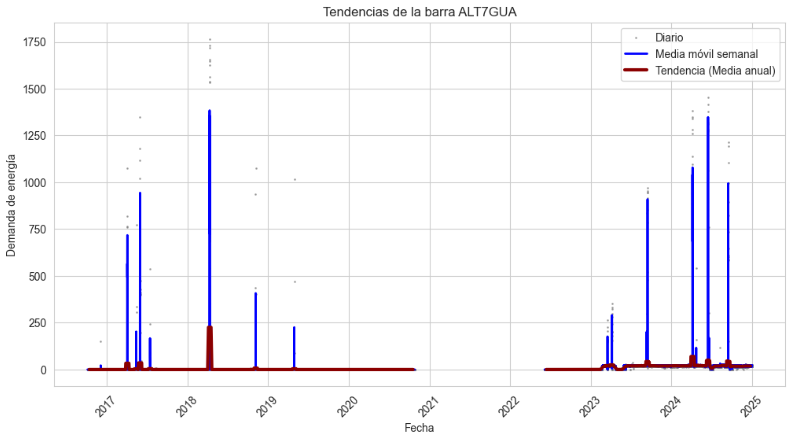


**ALT7TAR**

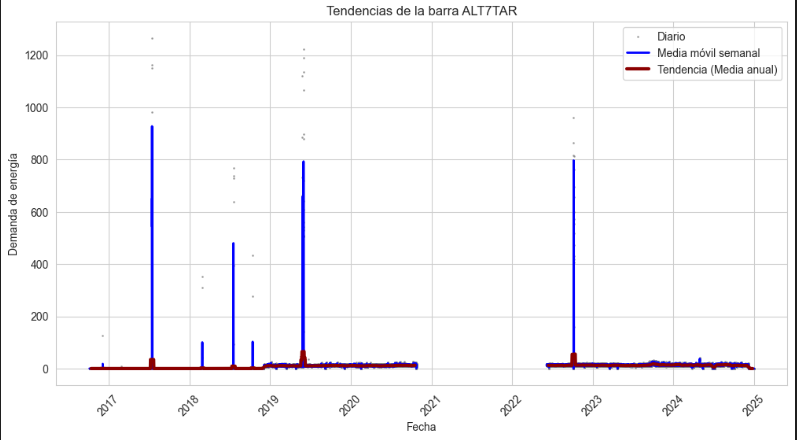

**BAL7MOT**

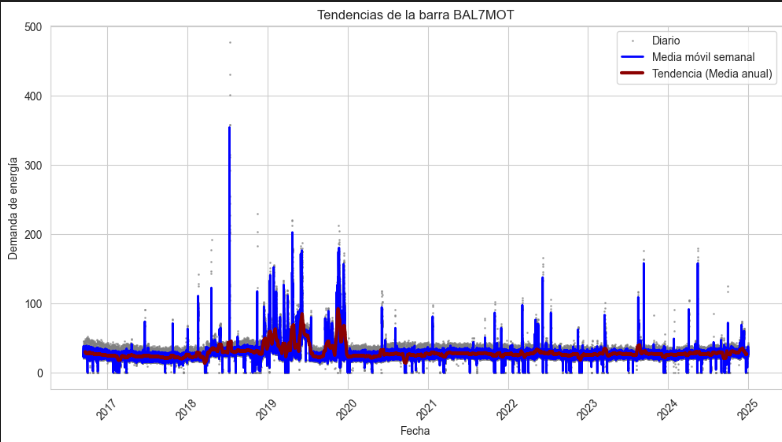

**BAR7SAN**

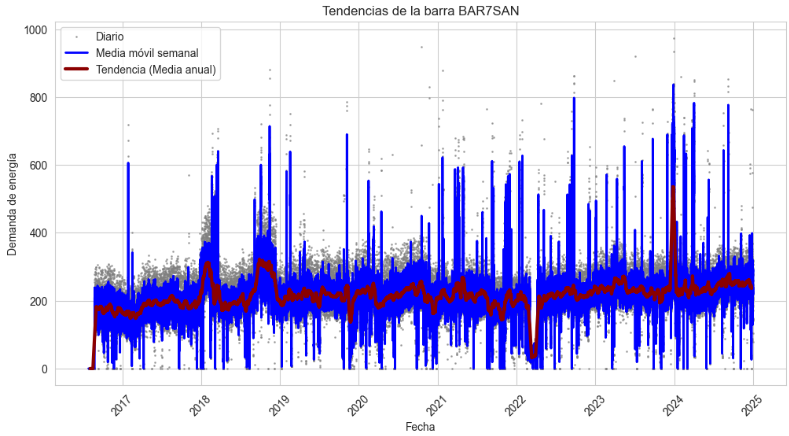

**CAS7LPT**	

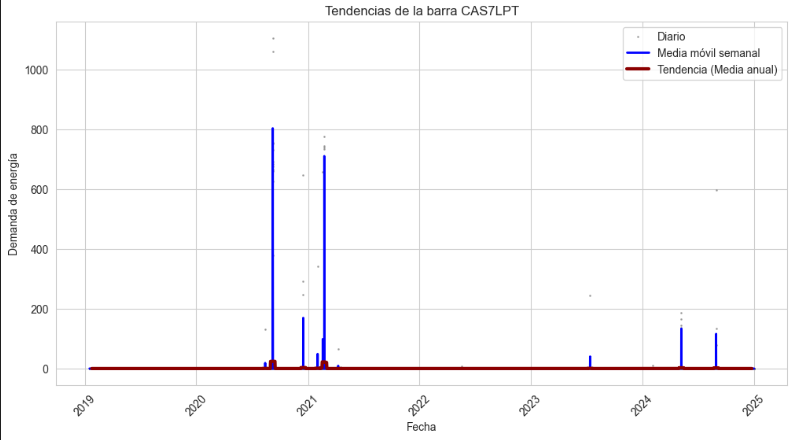

**FOR7VIV**

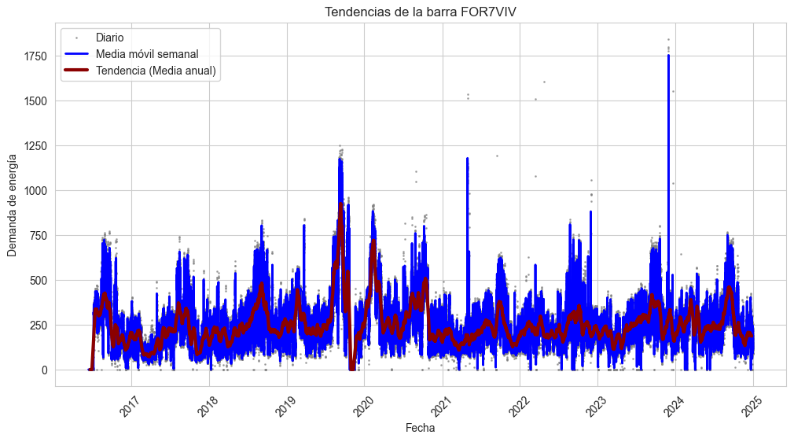

**Frt03787**

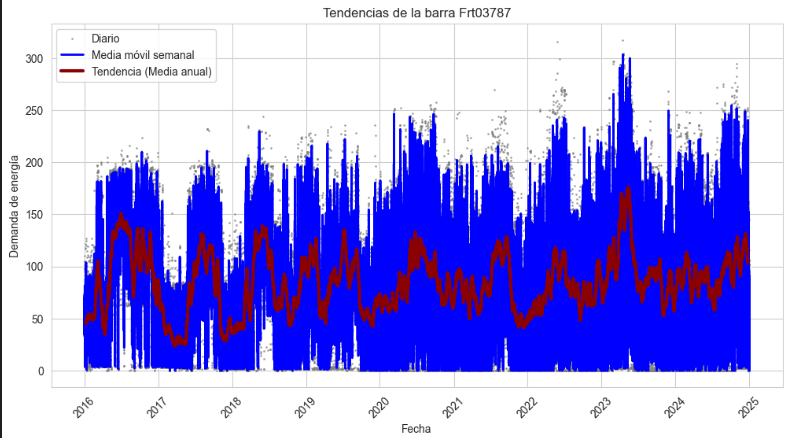

**Frt06573**

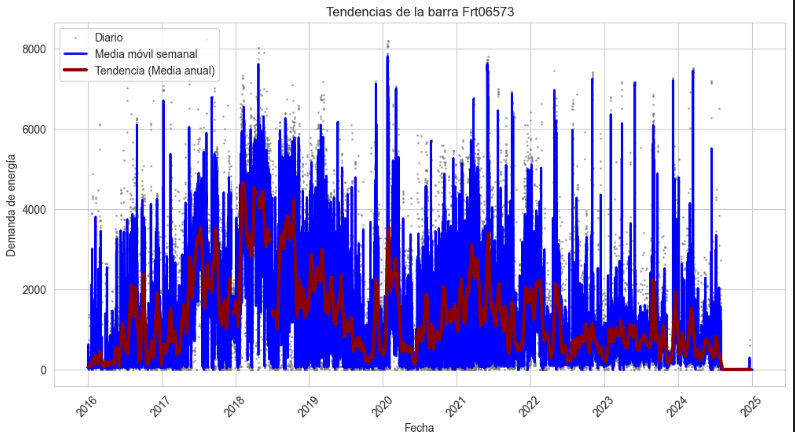

**Frt21446**

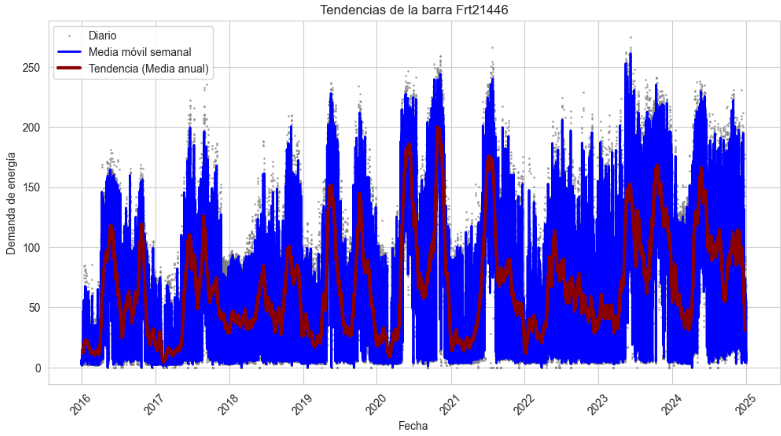

**Frt22192**

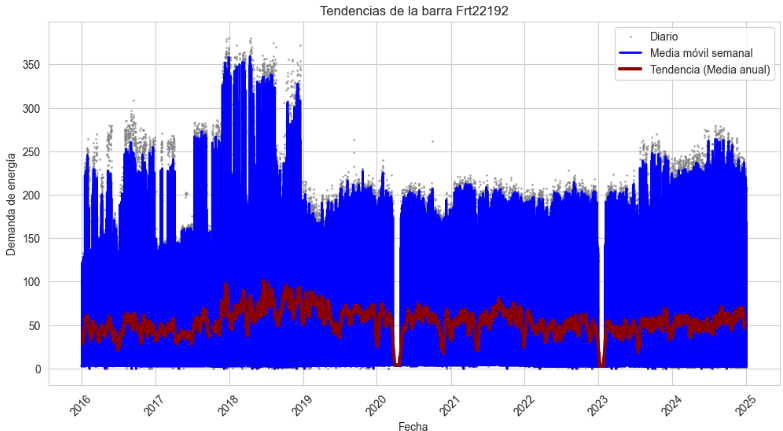

**Frt25832**

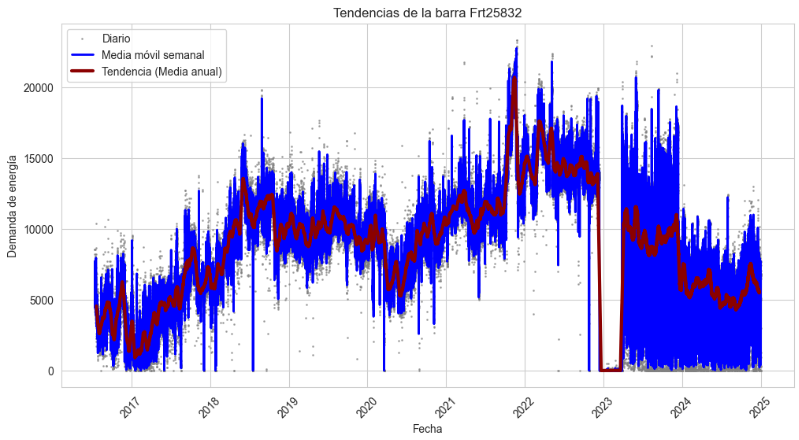

**Frt28160**

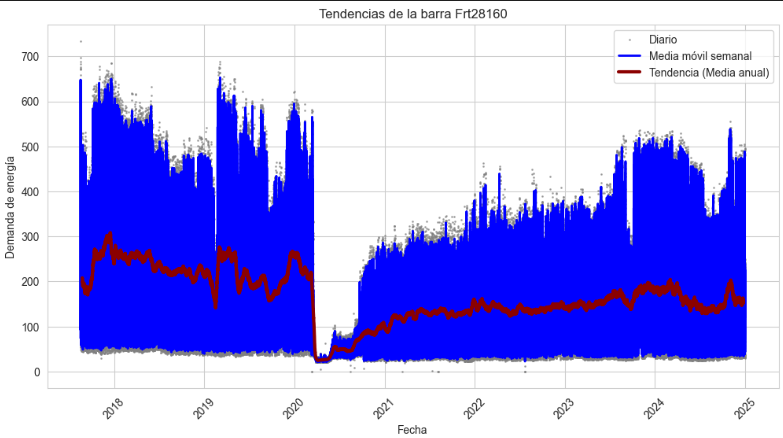

**Frt34220**

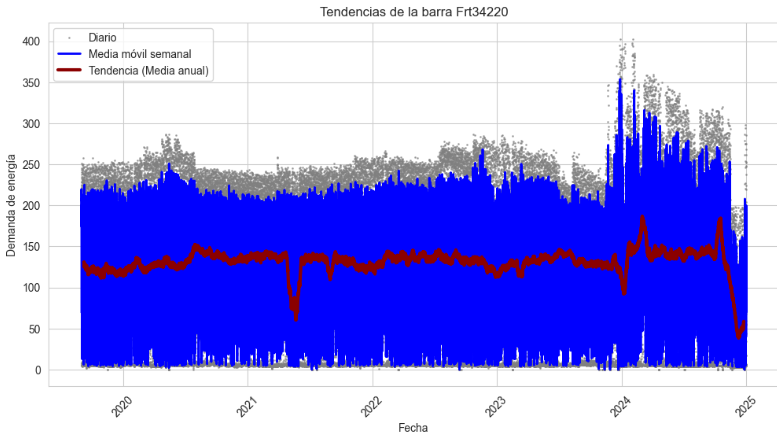

**Frt38282**

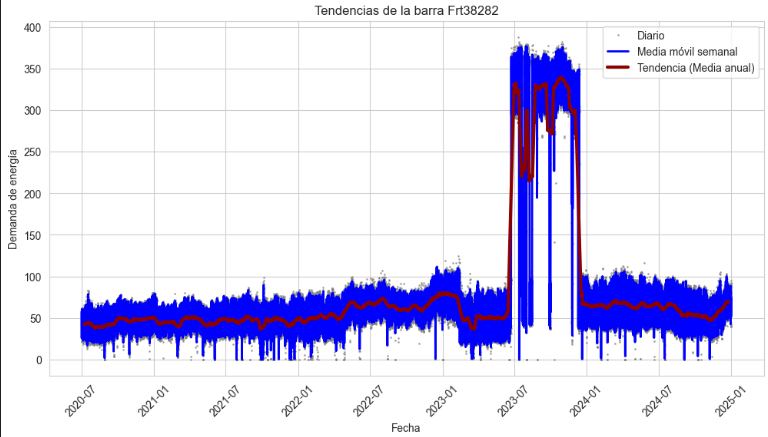

**GRZ7LPT**

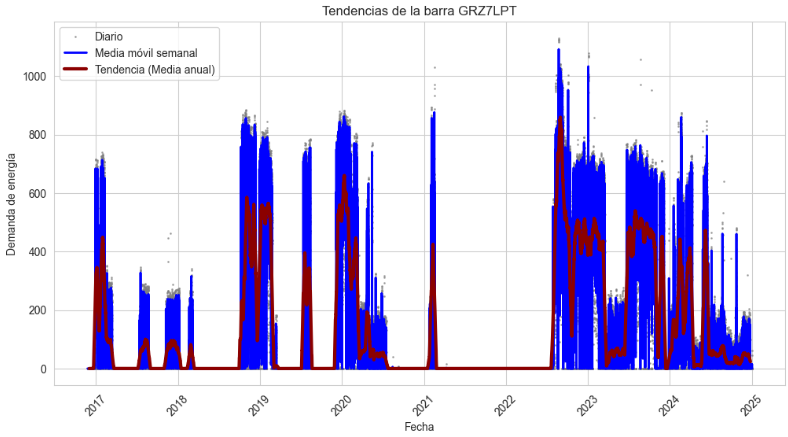

**GRZ7RLO**

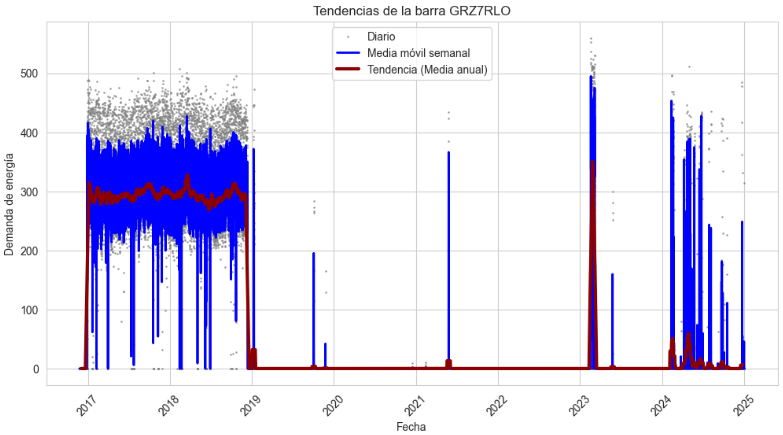

**GUA7ALT**

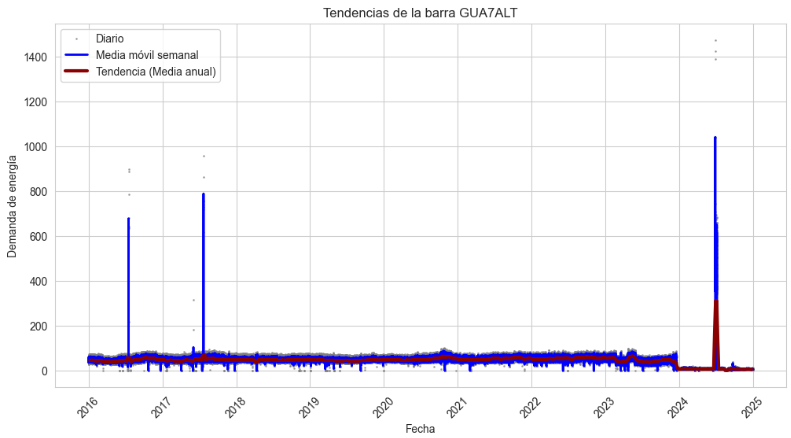

**JUN7SMG**

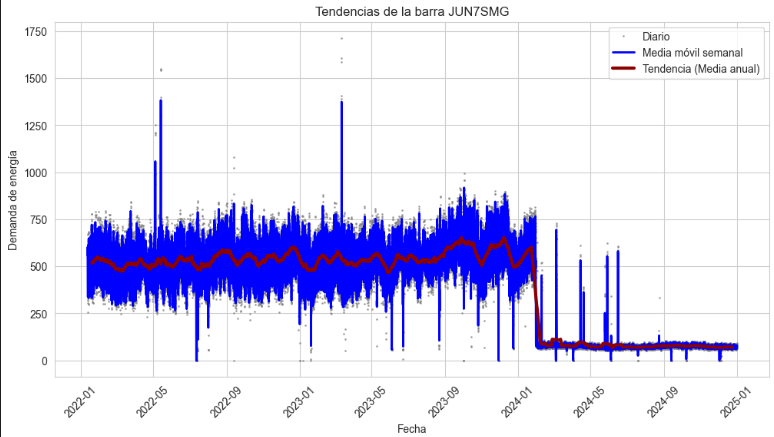

**NOR7VOL**

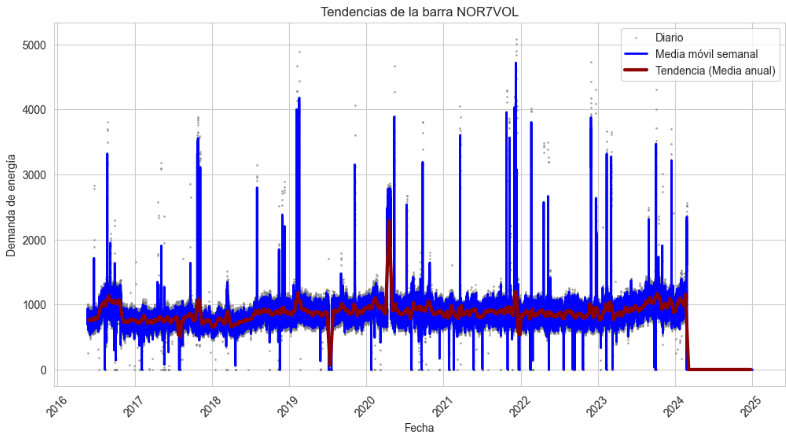

**ORI7VER**

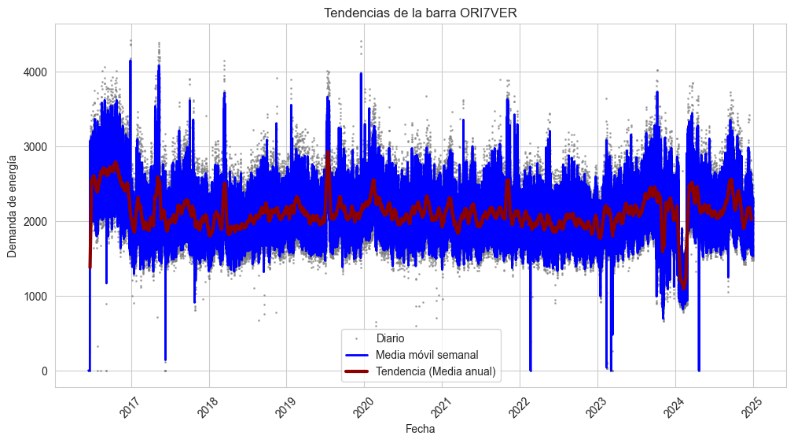


**PAI7NTG**

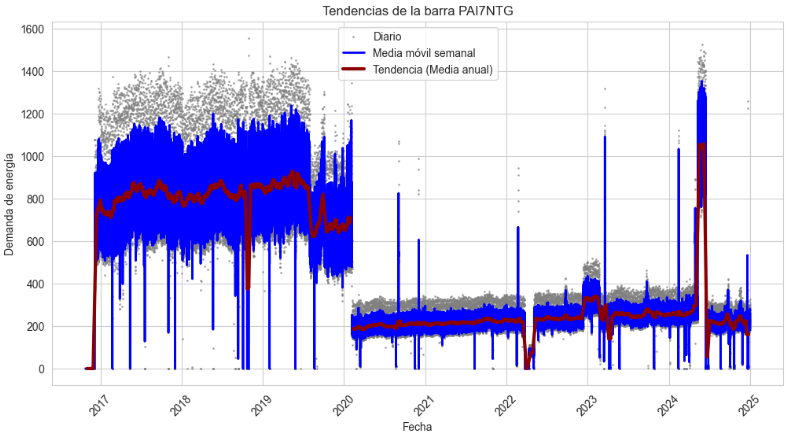

**PAL7JUN**

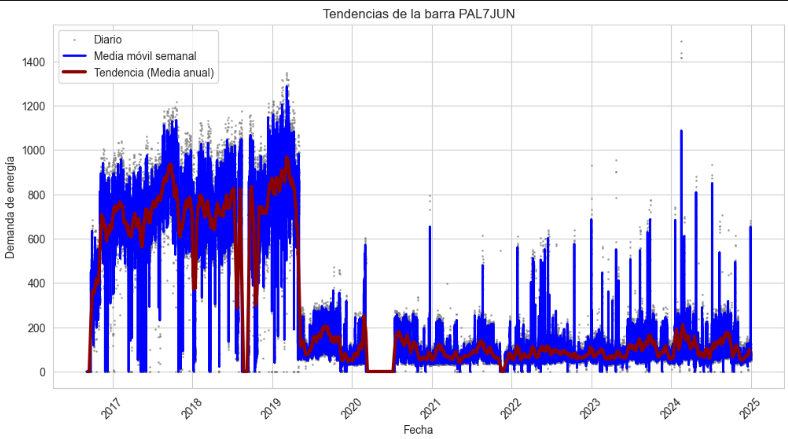

**PIP7PI3**

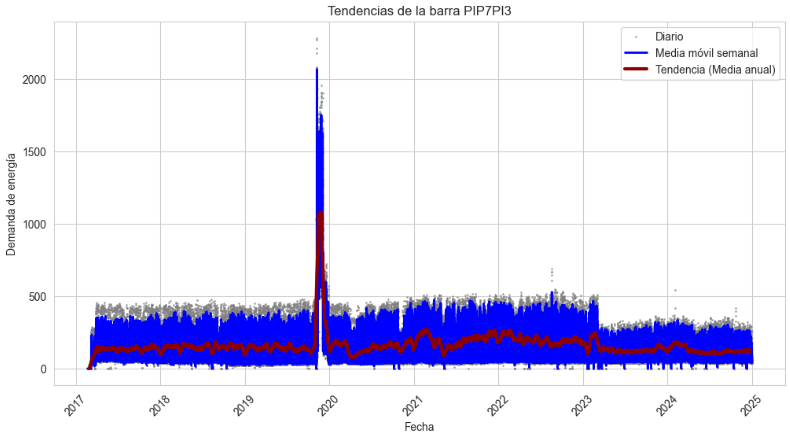

**RIV7ULL**

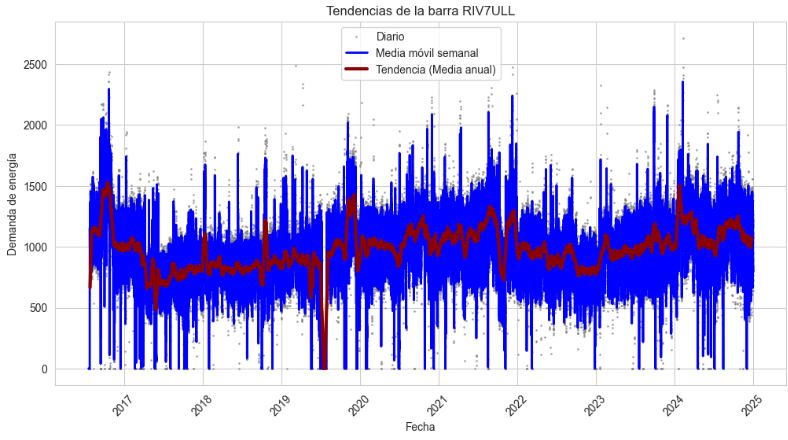

**SUR7AND**

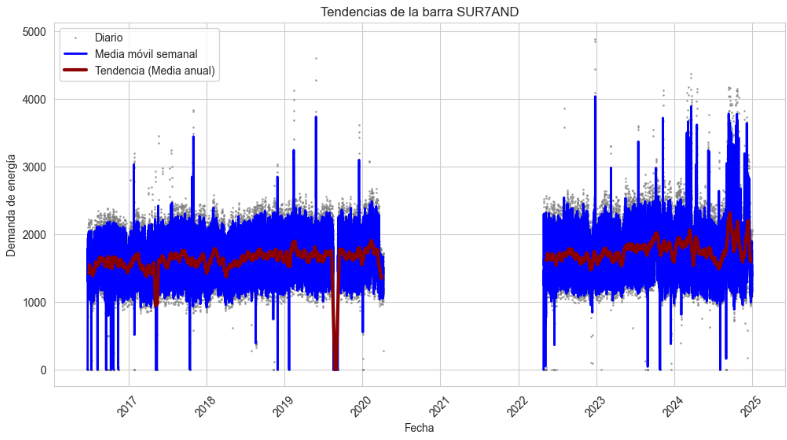


**TAR7ALT**

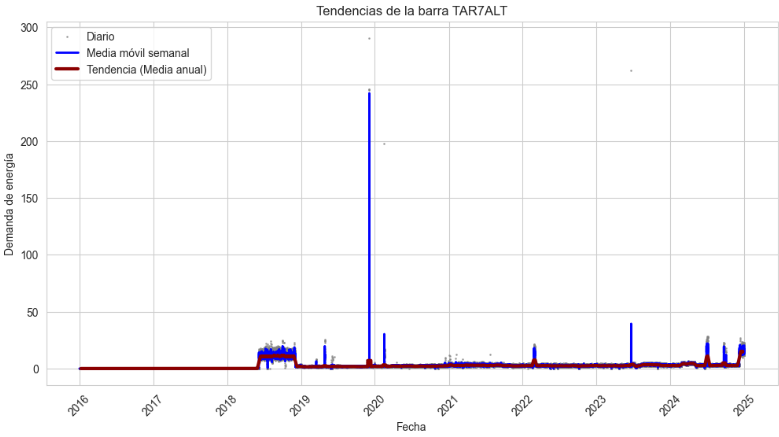


**YAG7RU1**

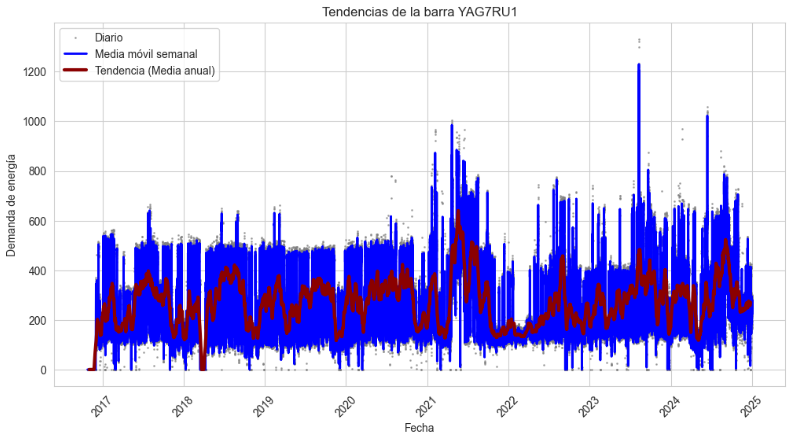

In [8]:

density_plot_pdf(df_original, ruta_guardado="../files/output/Graficos_Densidad/", name="1.density_plots")

C:\Users\user\AppData\Local\Temp\ipykernel_17288\3942438728.py:242: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_17288\3942438728.py:243: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  pdf.savefig(fig)  # Guardar la página en el PDF


Gráfica guardada en: ../files/output/Graficos_Densidad/1.density_plots.pdf


In [9]:
missing_values_heatmap(df_original,0,20,bar=False, ruta_guardado="../files/output/Grafico_valores_faltantes/Mapa_calor/")

Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/0-20.png


In [15]:
Bandera=0
rango=20
while Bandera< df_original.shape[1]:
    missing_values_heatmap(df_original,Bandera,rango,bar=False, ruta_guardado="../files/output/Grafico_valores_faltantes/Mapa_calor/")
    Bandera+=20
    rango+=20

Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/0-20.png
Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/20-40.png


d:\Propuesta_grado\Trabajo_grado\.venv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\user\AppData\Local\Temp\ipykernel_17288\3942438728.py:40: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(filepath, bbox_inches='tight')  # Guarda la gráfica


Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/40-60.png
Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/60-80.png
Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/80-100.png
Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/100-120.png
Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/120-140.png
Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/140-160.png
Gráfica guardada en: ../files/output/Grafico_valores_faltantes/Mapa_calor/160-180.png


In [16]:
datos_fantantes=tabla_datos_faltantes(df_original)
datos_fantantes.to_excel("../files/output/Tabla_datos_Faltantes.xlsx")

El dataframe seleccionado tiene 172 columnas.
Hay 162 columnas con valores perdidos.


In [17]:
for name in df_original.columns:
    graficar_tendencias(df_original[name],name,False)

Gráfica guardada en: ../files/output/Graficos_tendencias/ACE7RUR.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ACE7SAD.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ACE7URB.png
Gráfica guardada en: ../files/output/Graficos_tendencias/AIP7GUA.png
Gráfica guardada en: ../files/output/Graficos_tendencias/AIP7SAF.png
Gráfica guardada en: ../files/output/Graficos_tendencias/AIP7URB.png
Gráfica guardada en: ../files/output/Graficos_tendencias/AIP7VIV.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ALG7ARC.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ALG7PRS.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ALG7URB.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ALT7GUA.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ALT7SUA.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ALT7TAR.png
Gráfica guardada en: ../files/output/Graficos_tendencias/ALT7URB.png
Gráfica guardada en: ../files/outp

# Analisamos sin hacer tratamiento de datos 

In [18]:
df_drop_row=df_original[["ACE7RUR"]].copy()

In [19]:
df_drop_row.dropna(inplace=True)

In [20]:
(df_drop_row == 0).sum().sum()

np.int64(1580)

recordar verificar esto

In [21]:
resultado = porcentaje_horas_con_cero(df_drop_row)
print(resultado)

Horas con al menos un valor cero por cada hora del día:
FECHA_HORA
0     56
1     57
2     58
3     58
4     58
5     59
6     63
7     62
8     75
9     77
10    79
11    79
12    86
13    84
14    78
15    76
16    66
17    60
18    62
19    62
20    57
21    56
22    56
23    56
dtype: int64
None


In [22]:
# Crear el scaler
scaler = StandardScaler()

# Escalar los datos y reconstruir el DataFrame con el índice original
scaled_data = pd.DataFrame(scaler.fit_transform(df_drop_row), 
                           columns=df_drop_row.columns, 
                           index=df_drop_row.index)

print(scaled_data.head())

                      ACE7RUR
FECHA_HORA                   
2016-10-25 15:00:00 -2.453322
2016-10-25 16:00:00 -2.453322
2016-10-25 17:00:00 -2.453322
2016-10-25 18:00:00 -2.453322
2016-10-25 19:00:00 -2.453322


# Separar los datos de entrenamiento, prueba y validación

In [23]:
data = scaled_data[scaled_data.index.year < 2024].values
data_valid= scaled_data[scaled_data.index.year >= 2024].values

training_data_len = int(np.ceil(len(data) * 0.85))  # 85 % data para entrenamiento
test_data_len = len(data) - training_data_len  # 15% data para test

training_data = data[:-test_data_len]  # Toma el 85% de los datos para entrenamiento
test_data = data[-test_data_len:]  # Toma el 15% restante para prueba


In [24]:
print(f"Total de datos de Entrenamiento: {training_data_len}")
print(f"Total de datos de Prueba: {test_data_len}")
print(f"Total de datos de Validación: {len(data_valid)}")

Total de datos de Entrenamiento: 52987
Total de datos de Prueba: 9350
Total de datos de Validación: 8784


In [25]:
print(training_data.shape)
print(test_data.shape)
print(data_valid.shape)

(52987, 1)
(9350, 1)
(8784, 1)


# Crear ventana de tiempo

In [26]:
# Filtrado de datos
data = scaled_data[scaled_data.index.year < 2024].values
data_valid = scaled_data[scaled_data.index.year >= 2024].values

# División de datos para entrenamiento y prueba
training_data_len = int(np.ceil(len(data) * 0.85))  # 85% para entrenamiento
test_data_len = len(data) - training_data_len  # 15% para prueba

training_data = data[:training_data_len]  # Toma el 85% de los datos para entrenamiento
test_data = data[training_data_len:]  # Toma el 15% restante para prueba

X_train, y_train = [], []
window_slide = 24  # 24 días

# Construcción de datos de entrenamiento
for i in range(window_slide, len(training_data)):
    X_train.append(training_data[i - window_slide:i, :])  # Todas las variables
    y_train.append(training_data[i, -1])  # Última columna como variable objetivo

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Construcción de datos de validación
X_val, y_val = [], []
for i in range(window_slide, len(data_valid)):
    X_val.append(data_valid[i - window_slide:i, :])  # Todas las variables
    y_val.append(data_valid[i, -1])  # Última columna como variable objetivo

X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_train.shape[2]))

# Construir el modelo

In [27]:
# Definir modelo
model = keras.models.Sequential()

# Añadir capas LSTM
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.2))

# Añadir capas densas
model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

d:\Propuesta_grado\Trabajo_grado\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss="mae",
              metrics=[keras.metrics.R2Score()])

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Entrenar

In [31]:
training = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=40, 
                    batch_size=64, 
                    callbacks=[early_stopping, lr_scheduler])

model.save("mi_modelo.keras")

Epoch 1/40
828/828 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - loss: 0.8311 - r2_score: 0.6538 - val_loss: 0.3499 - val_r2_score: 0.7886 - learning_rate: 0.0010
Epoch 2/40
828/828 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 0.2497 - r2_score: 0.8600 - val_loss: 0.3386 - val_r2_score: 0.7935 - learning_rate: 0.0010
Epoch 3/40
828/828 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 0.2292 - r2_score: 0.8705 - val_loss: 0.3021 - val_r2_score: 0.8142 - learning_rate: 0.0010
Epoch 4/40
828/828 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 0.2172 - r2_score: 0.8809 - val_loss: 0.2565 - val_r2_score: 0.8513 - learning_rate: 0.0010
Epoch 5/40
828/828 ━━━━━━━━━━━━━━━━━━━━ 77s 51ms/step - loss: 0.2046 - r2_score: 0.8957 - val_loss: 0.2409 - val_r2_score: 0.8772 - learning_rate: 0.0010
Epoch 6/40
828/828 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - loss: 0.1941 - r2_score: 0.9065 - val_loss: 0.2117 - val_r2_score: 0.9004 - learning_rate: 0.0010
Epoch 7/40
828/828 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - loss: 0.1863 - r2_sc

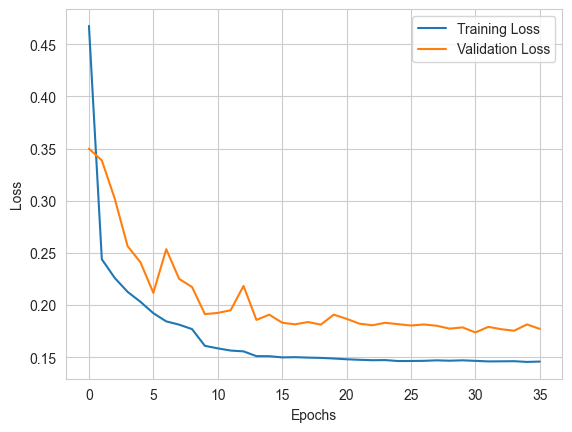

In [32]:
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Resultados

In [33]:
# Preparar los datos de test
test_data = scaled_data.iloc[training_data_len - window_slide:]  # Asegurar que sea DataFrame

# Construir X_test y y_test
X_test, y_test = [], test_data.iloc[window_slide:, -1].values  # Última columna como variable objetivo

# Construcción de X_test
for i in range(window_slide, len(test_data)):
    X_test.append(test_data.iloc[i - window_slide:i].values)  # Tomar todas las variables

# Convertir a array de NumPy
X_test = np.array(X_test)

# Ajustar la forma de X_test dinámicamente
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [ ]:
predictions = model.predict(X_test)
predictions = np.repeat(predictions, 1, axis=1)
predictions_final = scaler.inverse_transform(predictions)

In [ ]:
# Definir las variables de entrenamiento y prueba usando la última columna del DataFrame
train = df_drop_row.iloc[:training_data_len, -1]  # Última columna como variable objetivo (entrenamiento)
test = df_drop_row.iloc[training_data_len:, -1]   # Última columna como variable objetivo (prueba)

# Convertir a arrays de NumPy si es necesario
train = train.values
test = test.values

predictions = predictions_final[:, -1]  # Selecciona la última columna de las predicciones
# Asegurar que 'predictions' tenga la misma cantidad de filas que 'test'
predictions = pd.DataFrame(predictions, index=df_drop_row.index[training_data_len:], columns=["Predictions"])
predictions.head(1)

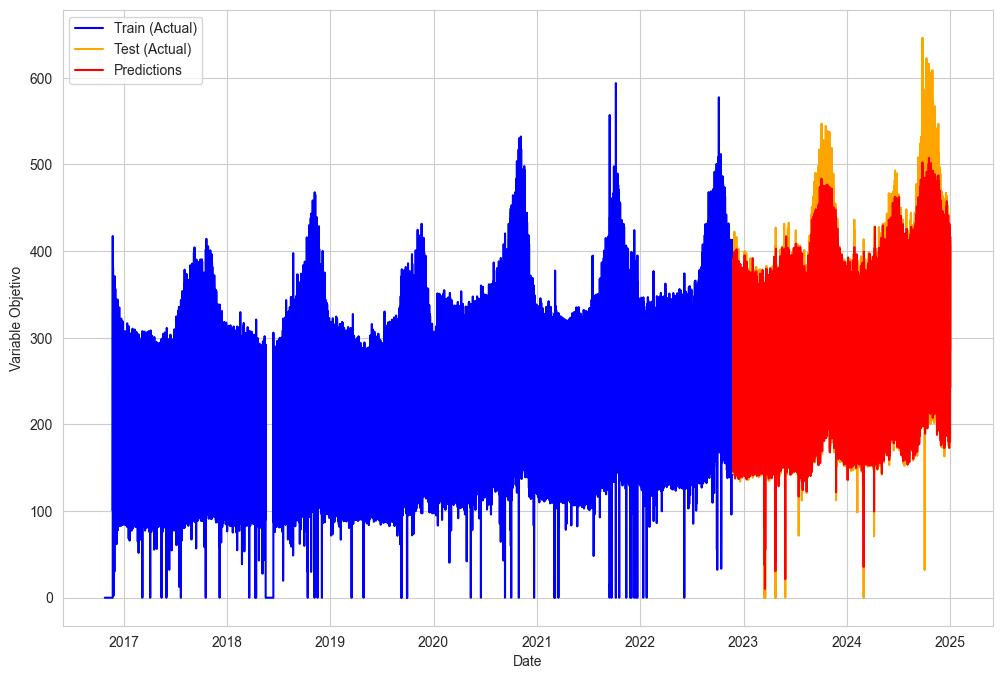

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Graficar los datos con los índices originales
plt.plot(df_drop_row.index[:training_data_len], train, label="Train (Actual)", color='blue')
plt.plot(df_drop_row.index[training_data_len:], test, label="Test (Actual)", color='orange')
plt.plot(df_drop_row.index[training_data_len:], predictions, label="Predictions", color='red')

plt.xlabel("Date")
plt.ylabel("Variable Objetivo")  # Cambiar esto si sabes el nombre correcto de la variable
plt.legend()
plt.grid(True)
plt.show()


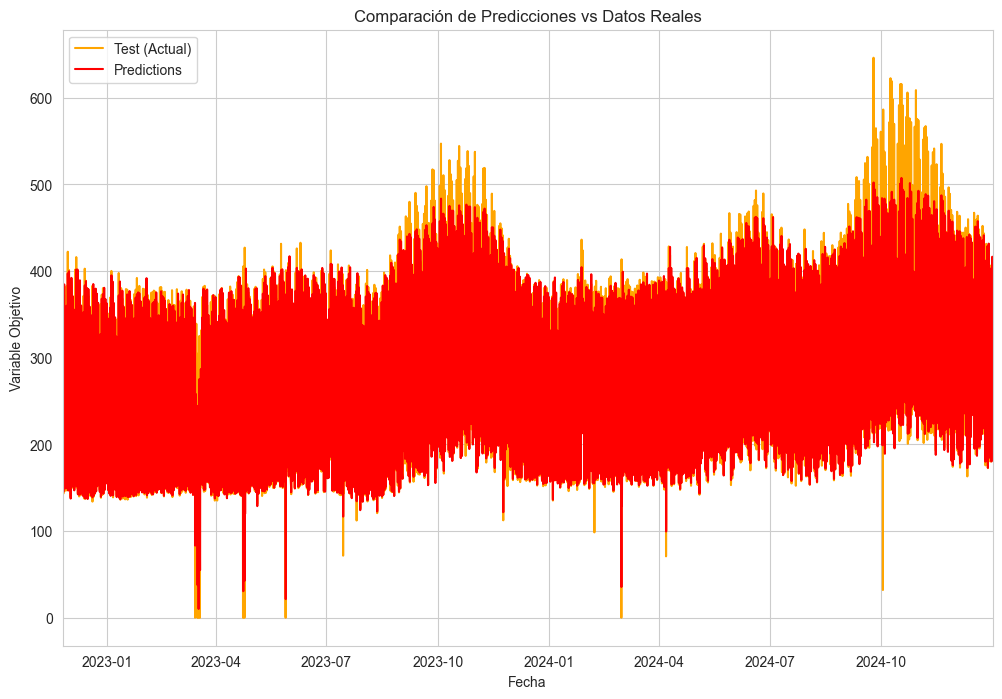

In [42]:
import matplotlib.pyplot as plt

# Asegurar que test tenga índice (si es un array, convertirlo en Serie)
if isinstance(test, np.ndarray):
    test = pd.Series(test, index=df_drop_row.index[training_data_len:], name="Test (Actual)")

# Definir el periodo de las predicciones
start_date = predictions.index.min()  # Primer día de las predicciones
end_date = predictions.index.max()    # Último día de las predicciones

plt.figure(figsize=(12,8))

# Graficar datos de prueba
plt.plot(test.index, test, label="Test (Actual)", color='orange')

# Graficar predicciones
plt.plot(predictions.index, predictions, label="Predictions", color='red')

# Ajustar el rango de fechas (zoom en el periodo de las predicciones)
plt.xlim(start_date, end_date)

plt.xlabel("Fecha")
plt.ylabel("Variable Objetivo")
plt.legend()
plt.title("Comparación de Predicciones vs Datos Reales")
plt.grid(True)
plt.show()


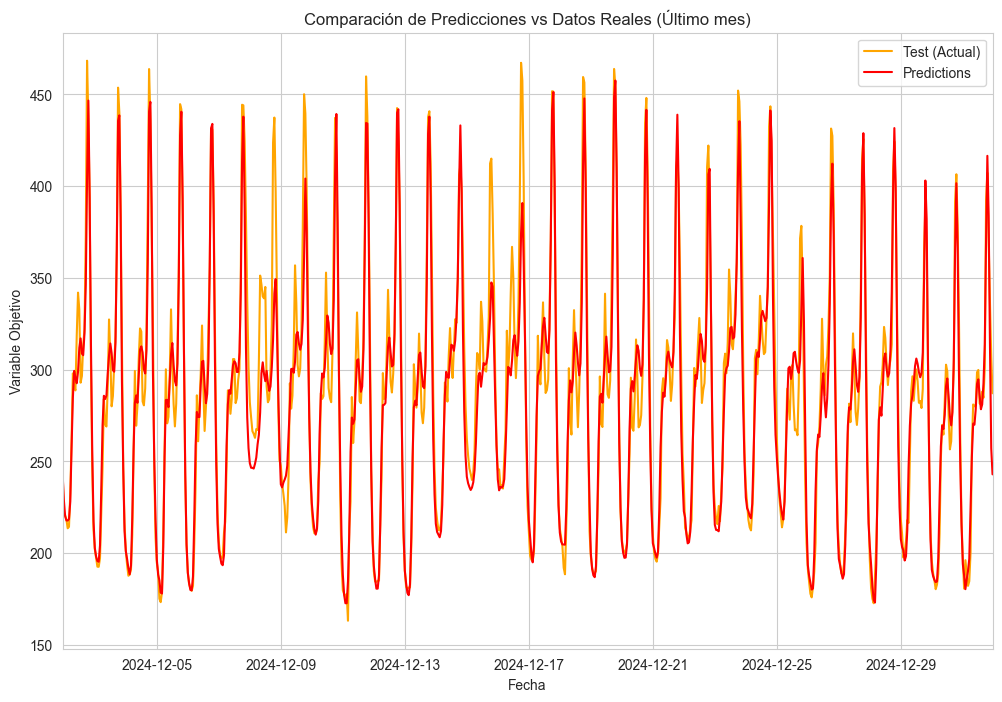

In [44]:
import matplotlib.pyplot as plt

# Asegurar que test tenga índice (si es un array, convertirlo en Serie)
if isinstance(test, np.ndarray):
    test = pd.Series(test, index=df_drop_row.index[training_data_len:], name="Test (Actual)")

# Definir el periodo de predicciones
start_date = predictions.index.min()  
end_date = predictions.index.max()

# Definir el rango de zoom en el último mes (30 días antes del final de las predicciones)
start_date_zoom = end_date - pd.Timedelta(days=30)  

plt.figure(figsize=(12, 8))

# Filtrar datos para el rango de zoom
test_zoom = test.loc[start_date_zoom:end_date]
predictions_zoom = predictions.loc[start_date_zoom:end_date]

# Graficar datos de prueba en el rango seleccionado
plt.plot(test_zoom.index, test_zoom, label="Test (Actual)", color='orange')

# Graficar predicciones en el rango seleccionado
plt.plot(predictions_zoom.index, predictions_zoom, label="Predictions", color='red')

# Ajustar el rango de fechas
plt.xlim(start_date_zoom, end_date)

plt.xlabel("Fecha")
plt.ylabel("Variable Objetivo")
plt.legend()
plt.title("Comparación de Predicciones vs Datos Reales (Último mes)")
plt.grid(True)
plt.show()


In [45]:
import numpy as np
import pandas as pd

# Definir la cantidad de días a predecir (365 días para un año)
dias_a_predecir = 365  

# Tomar la última ventana de datos para hacer predicciones futuras
last_window = scaled_data[-window_slide:].values

# Lista para almacenar predicciones futuras
future_predictions = []

# Generar predicciones día a día
for _ in range(dias_a_predecir):
    # Convertir la ventana en un array de entrada para la LSTM
    input_data = np.array(last_window).reshape(1, window_slide, X_train.shape[2])

    # Hacer la predicción
    predicted_value = model.predict(input_data)[0, 0]  # Tomar el valor predicho

    # Guardar la predicción
    future_predictions.append(predicted_value)

    # Desplazar la ventana de entrada (agregar la nueva predicción y eliminar la más antigua)
    last_window = np.vstack([last_window[1:], np.append(last_window[-1, :-1], predicted_value)])

# Convertir predicciones a DataFrame con índice de fechas futuras
start_date = scaled_data.index.max() + pd.Timedelta(days=1)  # Día siguiente al último dato conocido
future_dates = pd.date_range(start=start_date, periods=dias_a_predecir, freq='D')

predictions_2025 = pd.DataFrame(future_predictions, index=future_dates, columns=["Predictions"])

# Mostrar las primeras filas de las predicciones futuras
predictions_2025.head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

Predictions
2025-01-01 23:00:00     0.406977
2025-01-02 23:00:00     0.172364
2025-01-03 23:00:00    -0.010382
2025-01-04 23:00:00    -0.119895
2025-01-05 23:00:00    -0.186882

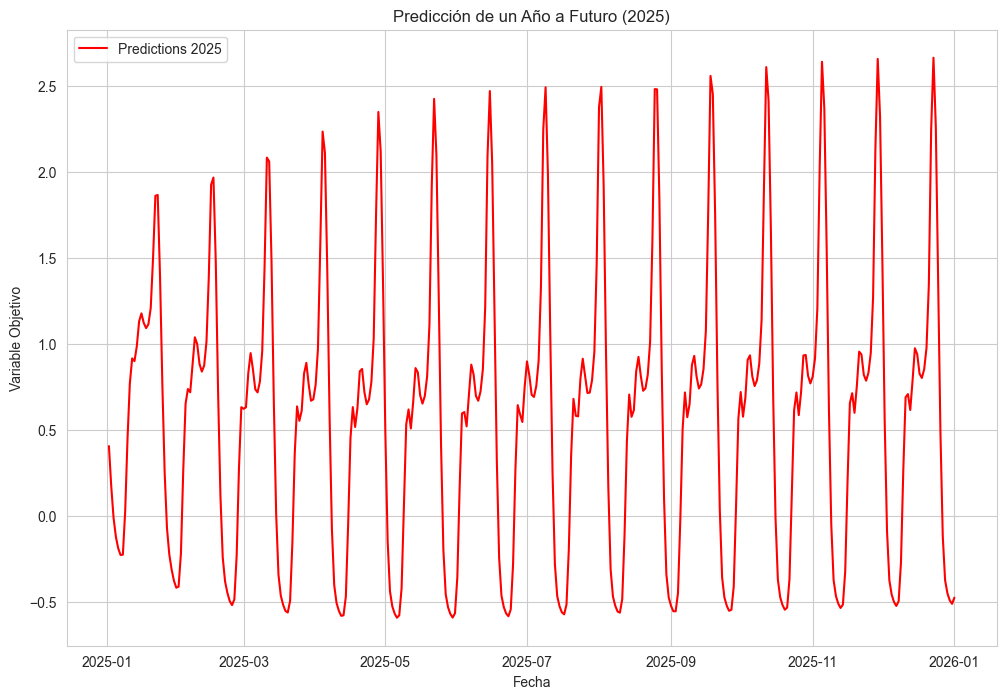

In [46]:


plt.figure(figsize=(12, 8))

# Graficar predicciones futuras
plt.plot(predictions_2025.index, predictions_2025, label="Predictions 2025", color='red')

plt.xlabel("Fecha")
plt.ylabel("Variable Objetivo")
plt.legend()
plt.title("Predicción de un Año a Futuro (2025)")
plt.grid(True)
plt.show()


## CIRCUITOS CON DATOS FALTANTES 

In [16]:
df_drop_row2=df_original[["ALT7URB"]].copy()
df_drop_row2.dropna(inplace=True)

# Crear el scaler
scaler = StandardScaler()

# Escalar los datos y reconstruir el DataFrame con el índice original
scaled_data = pd.DataFrame(scaler.fit_transform(df_drop_row2), 
                           columns=df_drop_row2.columns, 
                           index=df_drop_row2.index)

print(scaled_data.head())


data = scaled_data[scaled_data.index.year < 2024].values
data_valid= scaled_data[scaled_data.index.year >= 2024].values

training_data_len = int(np.ceil(len(data) * 0.85))  # 85 % data para entrenamiento
test_data_len = len(data) - training_data_len  # 15% data para test

training_data = data[:-test_data_len]  # Toma el 85% de los datos para entrenamiento
test_data = data[-test_data_len:]  # Toma el 15% restante para prueba

                      ALT7URB
FECHA_HORA                   
2016-10-05 17:00:00 -3.038437
2016-10-05 18:00:00 -3.038437
2016-10-05 19:00:00 -3.038437
2016-10-05 20:00:00 -3.038437
2016-10-05 21:00:00 -3.038437


# VENTANA

In [17]:
# Filtrado de datos
data = scaled_data[scaled_data.index.year < 2024].values
data_valid = scaled_data[scaled_data.index.year >= 2024].values

# División de datos para entrenamiento y prueba
training_data_len = int(np.ceil(len(data) * 0.85))  # 85% para entrenamiento
test_data_len = len(data) - training_data_len  # 15% para prueba

training_data = data[:training_data_len]  # Toma el 85% de los datos para entrenamiento
test_data = data[training_data_len:]  # Toma el 15% restante para prueba

X_train, y_train = [], []
window_slide = 24  # 24 días

# Construcción de datos de entrenamiento
for i in range(window_slide, len(training_data)):
    X_train.append(training_data[i - window_slide:i, :])  # Todas las variables
    y_train.append(training_data[i, -1])  # Última columna como variable objetivo

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Construcción de datos de validación
X_val, y_val = [], []
for i in range(window_slide, len(data_valid)):
    X_val.append(data_valid[i - window_slide:i, :])  # Todas las variables
    y_val.append(data_valid[i, -1])  # Última columna como variable objetivo

X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_train.shape[2]))

In [18]:
# Definir modelo
model = keras.models.Sequential()

# Añadir capas LSTM
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.2))

# Añadir capas densas
model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

d:\Propuesta_grado\Trabajo_grado\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss="mae",
              metrics=[keras.metrics.R2Score()])

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [20]:
training = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=40, 
                    batch_size=64, 
                    callbacks=[early_stopping, lr_scheduler])

model.save("mi_modelo.keras")

Epoch 1/40
655/655 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.8860 - r2_score: 0.6717 - val_loss: 0.3088 - val_r2_score: 0.6996 - learning_rate: 0.0010
Epoch 2/40
655/655 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - loss: 0.2393 - r2_score: 0.8607 - val_loss: 0.2638 - val_r2_score: 0.7136 - learning_rate: 0.0010
Epoch 3/40
655/655 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.2256 - r2_score: 0.8790 - val_loss: 0.2864 - val_r2_score: 0.7027 - learning_rate: 0.0010
Epoch 4/40
655/655 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.2142 - r2_score: 0.8793 - val_loss: 0.2511 - val_r2_score: 0.7433 - learning_rate: 0.0010
Epoch 5/40
655/655 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.2043 - r2_score: 0.8924 - val_loss: 0.2506 - val_r2_score: 0.7489 - learning_rate: 0.0010
Epoch 6/40
655/655 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - loss: 0.2025 - r2_score: 0.8926 - val_loss: 0.2249 - val_r2_score: 0.7677 - learning_rate: 0.0010
Epoch 7/40
655/655 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - loss: 0.1931 - r2_sc

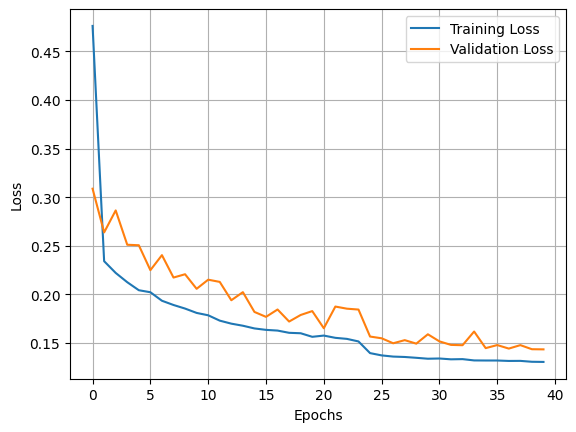

In [21]:
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Resultados 

In [22]:
# Preparar los datos de test
test_data = scaled_data.iloc[training_data_len - window_slide:]  # Asegurar que sea DataFrame

# Construir X_test y y_test
X_test, y_test = [], test_data.iloc[window_slide:, -1].values  # Última columna como variable objetivo

# Construcción de X_test
for i in range(window_slide, len(test_data)):
    X_test.append(test_data.iloc[i - window_slide:i].values)  # Tomar todas las variables

# Convertir a array de NumPy
X_test = np.array(X_test)

# Ajustar la forma de X_test dinámicamente
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [23]:
predictions = model.predict(X_test)
predictions = np.repeat(predictions, 1, axis=1)
predictions_final = scaler.inverse_transform(predictions)

506/506 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


In [25]:
# Definir las variables de entrenamiento y prueba usando la última columna del DataFrame
train = df_drop_row2.iloc[:training_data_len, -1]  # Última columna como variable objetivo (entrenamiento)
test = df_drop_row2.iloc[training_data_len:, -1]   # Última columna como variable objetivo (prueba)

# Convertir a arrays de NumPy si es necesario
train = train.values
test = test.values

predictions = predictions_final[:, -1]  # Selecciona la última columna de las predicciones
# Asegurar que 'predictions' tenga la misma cantidad de filas que 'test'
predictions = pd.DataFrame(predictions, index=df_drop_row2.index[training_data_len:], columns=["Predictions"])
predictions.head(1)

Predictions
FECHA_HORA                      
2023-02-26 18:00:00   280.169464

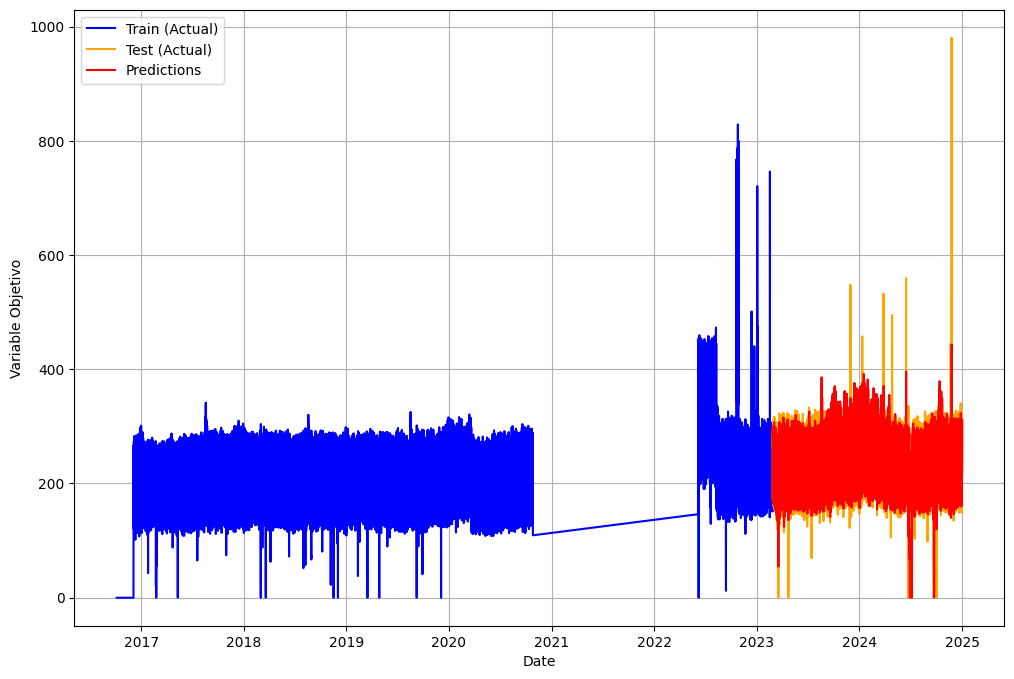

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Graficar los datos con los índices originales
plt.plot(df_drop_row2.index[:training_data_len], train, label="Train (Actual)", color='blue')
plt.plot(df_drop_row2.index[training_data_len:], test, label="Test (Actual)", color='orange')
plt.plot(df_drop_row2.index[training_data_len:], predictions, label="Predictions", color='red')

plt.xlabel("Date")
plt.ylabel("Variable Objetivo")  # Cambiar esto si sabes el nombre correcto de la variable
plt.legend()
plt.grid(True)
plt.show()

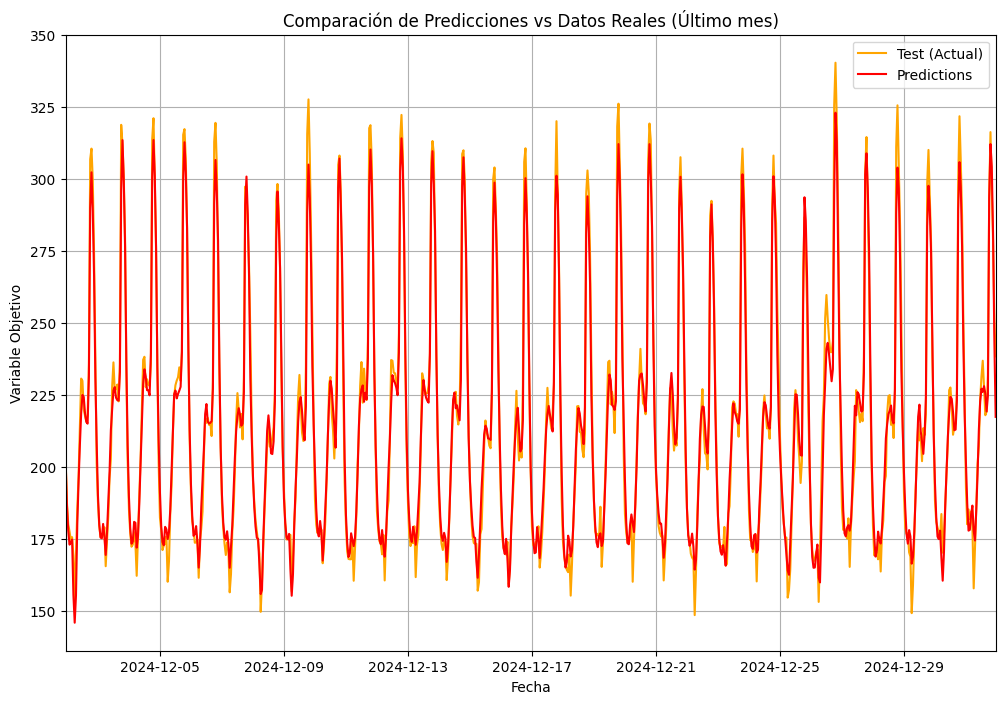

In [29]:
import matplotlib.pyplot as plt

# Asegurar que test tenga índice (si es un array, convertirlo en Serie)
if isinstance(test, np.ndarray):
    test = pd.Series(test, index=df_drop_row2.index[training_data_len:], name="Test (Actual)")

# Definir el periodo de predicciones
start_date = predictions.index.min()  
end_date = predictions.index.max()

# Definir el rango de zoom en el último mes (30 días antes del final de las predicciones)
start_date_zoom = end_date - pd.Timedelta(days=30)  

plt.figure(figsize=(12, 8))

# Filtrar datos para el rango de zoom
test_zoom = test.loc[start_date_zoom:end_date]
predictions_zoom = predictions.loc[start_date_zoom:end_date]

# Graficar datos de prueba en el rango seleccionado
plt.plot(test_zoom.index, test_zoom, label="Test (Actual)", color='orange')

# Graficar predicciones en el rango seleccionado
plt.plot(predictions_zoom.index, predictions_zoom, label="Predictions", color='red')

# Ajustar el rango de fechas
plt.xlim(start_date_zoom, end_date)

plt.xlabel("Fecha")
plt.ylabel("Variable Objetivo")
plt.legend()
plt.title("Comparación de Predicciones vs Datos Reales (Último mes)")
plt.grid(True)
plt.show()


In [30]:
import numpy as np
import pandas as pd

# Definir la cantidad de días a predecir (365 días para un año)
dias_a_predecir = 365  

# Tomar la última ventana de datos para hacer predicciones futuras
last_window = scaled_data[-window_slide:].values

# Lista para almacenar predicciones futuras
future_predictions = []

# Generar predicciones día a día
for _ in range(dias_a_predecir):
    # Convertir la ventana en un array de entrada para la LSTM
    input_data = np.array(last_window).reshape(1, window_slide, X_train.shape[2])

    # Hacer la predicción
    predicted_value = model.predict(input_data)[0, 0]  # Tomar el valor predicho

    # Guardar la predicción
    future_predictions.append(predicted_value)

    # Desplazar la ventana de entrada (agregar la nueva predicción y eliminar la más antigua)
    last_window = np.vstack([last_window[1:], np.append(last_window[-1, :-1], predicted_value)])

# Convertir predicciones a DataFrame con índice de fechas futuras
start_date = scaled_data.index.max() + pd.Timedelta(days=1)  # Día siguiente al último dato conocido
future_dates = pd.date_range(start=start_date, periods=dias_a_predecir, freq='D')

predictions_2025 = pd.DataFrame(future_predictions, index=future_dates, columns=["Predictions"])

# Mostrar las primeras filas de las predicciones futuras
predictions_2025.head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━

Predictions
2025-01-01 23:00:00     0.293461
2025-01-02 23:00:00     0.127631
2025-01-03 23:00:00     0.016304
2025-01-04 23:00:00    -0.063941
2025-01-05 23:00:00    -0.135757

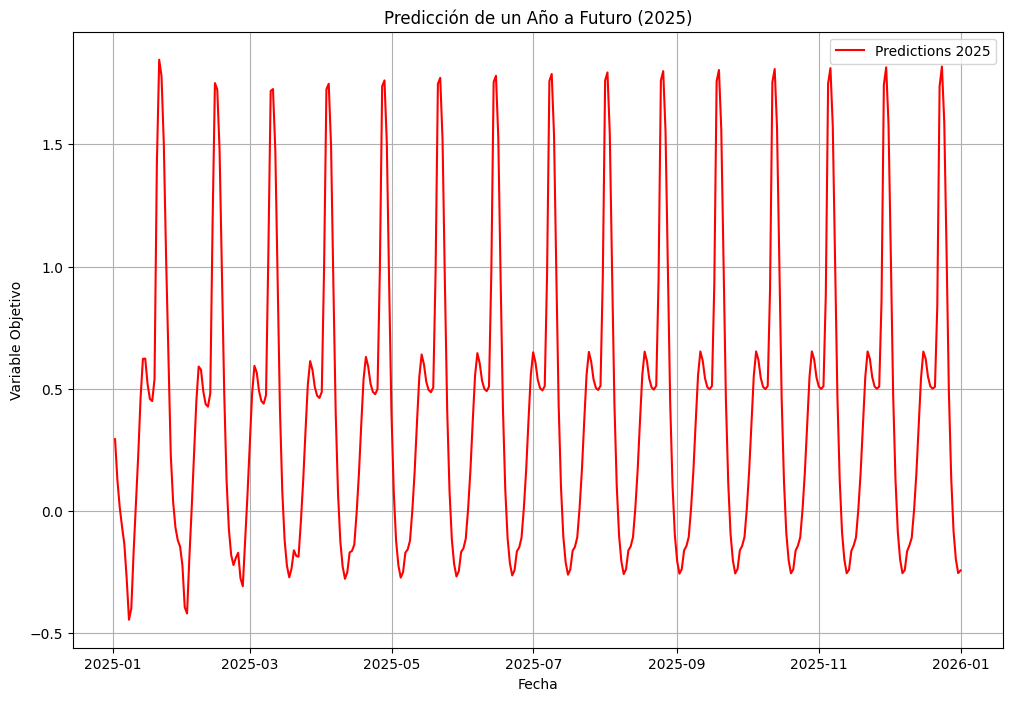

In [31]:


plt.figure(figsize=(12, 8))

# Graficar predicciones futuras
plt.plot(predictions_2025.index, predictions_2025, label="Predictions 2025", color='red')

plt.xlabel("Fecha")
plt.ylabel("Variable Objetivo")
plt.legend()
plt.title("Predicción de un Año a Futuro (2025)")
plt.grid(True)
plt.show()
